### Other Code (Not Used)

In [1]:
# # 1. Import libraries
# import torch
# import torch.nn as nn
# from data_utils import get_train_loader, get_val_loader, get_test_loader, set_seed
# from baseline_transformer_architecture import create_small_transformer
# from modeling_functions import validate_transformer
# from optimizer_scheduler import get_optimizer, get_plateau_scheduler, linear_teacher_scheduler
# from tokenizers import Tokenizer
# from tqdm.auto import tqdm
# import json
# import matplotlib.pyplot as plt
# from rouge_score import rouge_scorer


# # 2. Define label smoothing class
# class LabelSmoothingLoss(nn.Module):
#     def __init__(self, smoothing=0.1, ignore_index=1):
#         super().__init__()
#         self.smoothing = smoothing
#         self.ignore_index = ignore_index

#     def forward(self, pred, target):
#         with torch.no_grad():
#             true_dist = torch.zeros_like(pred)
#             true_dist.fill_(self.smoothing / (pred.size(1) - 1))
#             mask = target != self.ignore_index
#             target = target.masked_fill(~mask, 0)
#             true_dist.scatter_(1, target.unsqueeze(1), 1.0 - self.smoothing)
#             true_dist.masked_fill_(~mask.unsqueeze(1), 0)
#         return torch.mean(torch.sum(-true_dist * pred.log_softmax(dim=1), dim=1))


# # 3. Calculate rouge score
# def compute_rouge_score(preds, targets, tokenizer):
#     scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
#     scores = {'rouge1': 0, 'rouge2': 0, 'rougeL': 0}
#     for p, t in zip(preds, targets):
#         pred_text = tokenizer.decode(p.tolist(), skip_special_tokens=True)
#         target_text = tokenizer.decode(t.tolist(), skip_special_tokens=True)
#         score = scorer.score(target_text, pred_text)
#         for k in scores:
#             scores[k] += score[k].fmeasure
#     for k in scores:
#         scores[k] /= len(preds)
#     return scores

# # 4. Run model
# if __name__ == "__main__":
#     torch.cuda.empty_cache()
#     set_seed(42)
#     device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
#     config = {
#         "vocab_size": 20000,
#         "dropout": 0.1,
#         # "max_len": 512,
#         "d_model": 512,
#         "nhead": 8,
#         "num_encoder_layers": 4,
#         "num_decoder_layers": 4,
#         "dim_feedforward": 2048
#     }

#     tokenizer = Tokenizer.from_file("cnn_bpe_tokenizer_20k.json")
#     pad_idx = tokenizer.token_to_id("[PAD]")

#     model = create_small_transformer(**config).to(device)
#     optimizer = get_optimizer(model)
#     plateau_scheduler = get_plateau_scheduler(optimizer)
#     teacher_scheduler = linear_teacher_scheduler
#     criterion = LabelSmoothingLoss(smoothing=0.1, ignore_index=pad_idx)

#     train_loader = get_train_loader(tokenizer, batch_size=64, num_workers=2)
#     val_loader = get_val_loader(tokenizer, batch_size=64, num_workers=2)
#     test_loader = get_test_loader(tokenizer, batch_size=64, num_workers=2)

#     history = {
#         "train_loss": [],
#         "val_loss": [],
#         "train_rouge": {"rouge1": [], "rouge2": [], "rougeL": []},
#         "val_rouge": {"rouge1": [], "rouge2": [], "rougeL": []},
#         "test_loss": None,
#         "test_rouge": {},
#         "learning_rate": [],
#         "teacher_forcing_ratio": [],
#     }

#     for epoch in range(5):
#         model.train()
#         total_loss = 0
#         all_preds = []
#         all_targets = []
#         tf_ratio = teacher_scheduler.step()

#         for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/5"):
#             input_ids = batch["input_ids"].to(device)
#             labels = batch["labels"].to(device)
#             attn_mask = batch["attention_mask"].to(device)

#             optimizer.zero_grad()
#             output = model(
#                 src=input_ids,
#                 tgt=labels,
#                 src_key_padding_mask=(attn_mask == 0),
#                 teacher_forcing_ratio=tf_ratio
#             )
#             logits = output.view(-1, output.size(-1))
#             targets = labels[:, 1:].contiguous().view(-1)
#             loss = criterion(logits, targets)
#             loss.backward()
#             torch.nn.utils.clip_grad_norm_(model.parameters(), 2.0)
#             optimizer.step()
#             total_loss += loss.item()

#             pred_ids = logits.argmax(dim=-1).view(labels[:, 1:].shape)
#             all_preds.append(pred_ids.detach().cpu())
#             all_targets.append(labels[:, 1:].detach().cpu())

#         avg_train_loss = total_loss / len(train_loader)
#         rouge_scores_train = compute_rouge_score(torch.cat(all_preds), torch.cat(all_targets), tokenizer)

#         torch.cuda.empty_cache()
#         val_loss, val_scores = validate_transformer(model, val_loader, criterion, tokenizer, device, pad_idx, max_length_generate=40)

#         history["train_loss"].append(avg_train_loss)
#         history["val_loss"].append(val_loss)
#         for k in history["train_rouge"]:
#             history["train_rouge"][k].append(rouge_scores_train[k])
#             history["val_rouge"][k].append(val_scores[k])
#         history["learning_rate"].append(optimizer.param_groups[0]['lr'])
#         history["teacher_forcing_ratio"].append(tf_ratio)

#         plateau_scheduler.step(val_loss)
#         print(f"[Epoch {epoch+1}] Train Loss: {avg_train_loss:.4f}, Val Loss: {val_loss:.4f}, " +
#             ", ".join([f"Train {k.upper()}: {rouge_scores_train[k]:.4f}, Val {k.upper()}: {val_scores[k]:.4f}" for k in rouge_scores_train]))

#     torch.cuda.empty_cache()
#     model.eval()
#     total_test_loss = 0
#     all_preds = []
#     all_targets = []

#     with torch.no_grad():
#         for batch in test_loader:
#             input_ids = batch["input_ids"].to(device)
#             labels = batch["labels"].to(device)
#             attn_mask = batch["attention_mask"].to(device)

#             output = model(
#                 src=input_ids,
#                 tgt=labels,
#                 src_key_padding_mask=(attn_mask == 0)
#             )
#             logits = output.view(-1, output.size(-1))
#             targets = labels[:, 1:].contiguous().view(-1)
#             loss = criterion(logits, targets)
#             total_test_loss += loss.item()

#             pred_ids = logits.argmax(dim=-1).view(labels[:, 1:].shape)
#             all_preds.append(pred_ids.detach().cpu())
#             all_targets.append(labels[:, 1:].detach().cpu())

#     avg_test_loss = total_test_loss / len(test_loader)
#     test_rouge_scores = compute_rouge_score(torch.cat(all_preds), torch.cat(all_targets), tokenizer)
#     history["test_loss"] = avg_test_loss
#     history["test_rouge"] = test_rouge_scores

#     print(f"\n Test Loss: {avg_test_loss:.4f} | " + ", ".join([f"Test {k.upper()}: {v:.4f}" for k, v in test_rouge_scores.items()]))

#     with open("label_smooth_history_rouge.json", "w") as f:
#         json.dump(history, f, indent=2)

#     epochs = list(range(1, len(history["train_loss"]) + 1))

#     plt.figure(figsize=(10, 5))
#     plt.plot(epochs, history["train_loss"], label="Train Loss", marker="o")
#     plt.plot(epochs, history["val_loss"], label="Validation Loss", marker="s")
#     plt.axhline(y=history["test_loss"], color='r', linestyle='--', label=f"Test Loss: {history['test_loss']:.4f}")
#     plt.title("Loss Over Epochs")
#     plt.xlabel("Epoch")
#     plt.ylabel("Loss")
#     plt.legend()
#     plt.grid(True)
#     plt.tight_layout()
#     plt.savefig("loss_plot_rouge.png")
#     plt.show()

#     for k in ["rouge1", "rouge2", "rougeL"]:
#         plt.figure(figsize=(10, 5))
#         plt.plot(epochs, history["train_rouge"][k], label=f"Train {k.upper()}", marker="o")
#         plt.plot(epochs, history["val_rouge"][k], label=f"Validation {k.upper()}", marker="s")
#         plt.axhline(y=history["test_rouge"][k], color='g', linestyle='--', label=f"Test {k.upper()}: {history['test_rouge'][k]:.4f}")
#         plt.title(f"{k.upper()} F1 Over Epochs")
#         plt.xlabel("Epoch")
#         plt.ylabel(f"{k.upper()} F1 Score")
#         plt.legend()
#         plt.grid(True)
#         plt.tight_layout()
#         plt.savefig(f"{k}_plot_rouge.png")
#         plt.show()

### Import Libraries

In [1]:
# 1. Import libraries
import torch
import torch.nn as nn
from torch.optim.lr_scheduler import LambdaLR

from data_utils import get_train_loader, get_val_loader, get_test_loader, set_seed
from baseline_transformer_architecture import create_small_transformer
from modeling_functions import validate_transformer, generate_with_beam_search,calculate_and_save_rouge
from optimizer_scheduler import get_optimizer, get_plateau_scheduler, linear_teacher_scheduler
from visualization import visualize_training_dynamics, load_history

from tokenizers import Tokenizer
from tqdm.auto import tqdm
import json
import matplotlib.pyplot as plt
from rouge_score import rouge_scorer
import numpy as np

/home/catherine/anaconda3/envs/torch_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Define Functions

In [7]:
# 2. Define label smoothing class
class LabelSmoothingLoss(nn.Module):
    def __init__(self, smoothing=0.1, ignore_index=1):
        super().__init__()
        self.smoothing = smoothing
        self.ignore_index = ignore_index

    def forward(self, pred, target):
        with torch.no_grad():
            true_dist = torch.zeros_like(pred)
            true_dist.fill_(self.smoothing / (pred.size(1) - 1))
            mask = target != self.ignore_index
            target = target.masked_fill(~mask, 0)
            true_dist.scatter_(1, target.unsqueeze(1), 1.0 - self.smoothing)
            true_dist.masked_fill_(~mask.unsqueeze(1), 0)
        return torch.mean(torch.sum(-true_dist * pred.log_softmax(dim=1), dim=1))


# 3. Calculate rouge score
def compute_rouge_score(preds, targets, tokenizer):
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    scores = {'rouge1': 0, 'rouge2': 0, 'rougeL': 0}
    for p, t in zip(preds, targets):
        pred_text = tokenizer.decode(p.tolist(), skip_special_tokens=True)
        target_text = tokenizer.decode(t.tolist(), skip_special_tokens=True)
        score = scorer.score(target_text, pred_text)
        for k in scores:
            scores[k] += score[k].fmeasure
    for k in scores:
        scores[k] /= len(preds)
    return scores

# 4. Fixed Validation Function
# def validate_transformer(model, val_loader, criterion, tokenizer, device, pad_idx, max_length_generate=40):
#     scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
#     model.eval()
#     val_loss = 0
#     rouge_scores = {'rouge1': [], 'rouge2': [], 'rougeL': []}
#     total_samples = 0

#     with torch.no_grad():
#         for batch in val_loader:
#             try:
#                 # Move data to device
#                 input_ids = batch["input_ids"].to(device)
#                 target_ids = batch["labels"].to(device)
#                 attention_mask = batch["attention_mask"].to(device)
                
#                 # Forward pass
#                 output = model(
#                     input_ids,
#                     target_ids,
#                     src_key_padding_mask=(attention_mask == 0),
#                     teacher_forcing_ratio=0.0
#                 )
                
#                 # Calculate loss
#                 logits = output.view(-1, output.size(-1))
#                 targets = target_ids[:, 1:].contiguous().view(-1)
                
#                 # Filter padding tokens
#                 if pad_idx is not None:
#                     non_pad = targets.ne(pad_idx)
#                     logits = logits[non_pad]
#                     targets = targets[non_pad]
#                     if logits.numel() == 0:
#                         continue
                
#                 loss = criterion(logits, targets)
#                 val_loss += loss.item()
                
#                 # ROUGE calculation
#                 for i in range(len(input_ids)):
#                     pred_summary = greedy_decode(
#                         model,
#                         input_ids[i:i+1],
#                         tokenizer,
#                         device,
#                         max_length_generate
#                     )
#                     ref_summary = tokenizer.decode(
#                         target_ids[i].tolist(),
#                         skip_special_tokens=True
#                     )
                    
#                     scores = scorer.score(ref_summary, pred_summary)
#                     for key in rouge_scores:
#                         rouge_scores[key].append(scores[key].fmeasure)
                
#                 total_samples += len(input_ids)
                
#             except Exception as e:
#                 print(f"Validation error: {str(e)}")
#                 continue
    
#     # Calculate average metrics
#     avg_val_loss = val_loss / len(val_loader) if len(val_loader) > 0 else float('inf')
#     avg_rouge = {k: np.mean(v) if v else 0 for k, v in rouge_scores.items()}
    
#     return avg_val_loss, avg_rouge

### Training and Validation Phase

In [8]:
# Initialization
if __name__ == "__main__":
    torch.cuda.empty_cache()
    set_seed(42)
    device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
    
    # == Model Configuration --
    filename = "label_smoothing"
    config = {
        "vocab_size": 20000,
        "dropout": 0.1,
        "d_model": 512,
        "nhead": 8,
        "num_encoder_layers": 4,
        "num_decoder_layers": 4,
        "dim_feedforward": 2048
    }

    tokenizer = Tokenizer.from_file("cnn_bpe_tokenizer_20k.json")
    pad_idx = tokenizer.token_to_id("[PAD]")

    model = create_small_transformer(**config).to(device)
    optimizer = get_optimizer(model)
    plateau_scheduler = get_plateau_scheduler(optimizer)
    teacher_scheduler = linear_teacher_scheduler
    criterion = LabelSmoothingLoss(smoothing=0.1, ignore_index=pad_idx)

    train_loader = get_train_loader(tokenizer, batch_size=64, num_workers=2)
    val_loader = get_val_loader(tokenizer, batch_size=64, num_workers=2)
    test_loader = get_test_loader(tokenizer, batch_size=64, num_workers=2)

    history = {
        "train_loss": [],
        "val_loss": [],
        "train_rouge1": [],
        "train_rouge2": [],
        "train_rougeL": [],
        "rouge1": [], # validation rouge scores (named this way for visualization formatting)
        "rouge2": [],
        "rougeL": [],
        "learning_rate": [],
        "teacher_forcing_ratio": [],
        "global_step": 0

    }
    # Warmup scheduler configuration
    warmup_steps = 1 * len(train_loader)  # 1 epochs of batches
    initial_lr = 5e-5
    target_lr = 2e-4
    
    # Scaling from 5e-5 to 2e-4
    warmup_scheduler = LambdaLR(
    optimizer,
    lr_lambda=lambda step: (initial_lr + (target_lr - initial_lr) * min(1.0, step / warmup_steps))/ target_lr
    )
    
 # === Main code section ===
    for epoch in range(5):
        # === Training Phase ===
        model.train()
        total_loss = 0
        predictions, references = [], []

        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/5"):
            input_ids = batch["input_ids"].to(device)
            labels = batch["labels"].to(device)
            attn_mask = batch["attention_mask"].to(device)
            
            # Teacher forcing ratio
            if epoch < 2:
                tf_ratio = 0.9  # Warmup phase, keep the same
            else:
                tf_ratio = teacher_scheduler.step()

            optimizer.zero_grad()
            output = model(
                src=input_ids,
                tgt=labels,
                src_key_padding_mask=(attn_mask == 0),
                teacher_forcing_ratio=tf_ratio
            )
            logits = output.view(-1, output.size(-1))
            targets = labels[:, 1:].contiguous().view(-1)
            loss = criterion(logits, targets)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 2.0)
            optimizer.step()
            total_loss += loss.item()
            
            history['global_step'] += 1
                        
            # Learning rate warmup setting
            if history['global_step'] < warmup_steps:
                warmup_scheduler.step()
            
            # Calculate rouge score during training
            with torch.no_grad():
                predictions.append(output.argmax(dim=-1))
                references.append(labels[:, 1:])

        avg_train_loss = total_loss / len(train_loader)
        train_rouge_scores = compute_rouge_score(torch.cat(references), torch.cat(predictions),tokenizer)
        
        # empty unused memory after an epoch
        torch.cuda.empty_cache()
        
        # === Validation Phase ===
        
        val_loss, val_rouge_scores = validate_transformer(
            model, val_loader, criterion, tokenizer, device, pad_idx, max_length_generate=40)
        
        history["train_loss"].append(avg_train_loss)
        history["val_loss"].append(val_loss)
        history["learning_rate"].append(optimizer.param_groups[0]['lr'])
        history["teacher_forcing_ratio"].append(tf_ratio)
        
        for k in ["rouge1", "rouge2", "rougeL"]:
            history[f"train_{k}"].append(train_rouge_scores[k])
            history[f"{k}"].append(val_rouge_scores[f"{k}_mean"])

        # Update history and schedulers
        if epoch >= 2:
            plateau_scheduler.step(val_loss)

        print(f"[Epoch {epoch+1}] Train Loss: {avg_train_loss:.4f}, Val Loss: {val_loss:.4f}")
        for k in ["rouge1", "rouge2", "rougeL"]:
            print(f"  Train {k.upper()}: {train_rouge_scores[k]:.4f}, Val {k.upper()}: {val_rouge_scores[f'{k}_mean']:.4f}")
    
    # === Data and Final Model Saving ===
    torch.save(model.state_dict(), f"{filename}_final_model.pt")
    with open(f"{filename}_history.json", 'w') as f:
        json.dump(history, f, indent=4)
        
    # torch.cuda.empty_cache()
    # model.eval()
    # total_test_loss = 0
    # all_preds = []
    # all_targets = []

    # with torch.no_grad():
    #     for batch in test_loader:
    #         input_ids = batch["input_ids"].to(device)
    #         labels = batch["labels"].to(device)
    #         attn_mask = batch["attention_mask"].to(device)

    #         output = model(
    #             src=input_ids,
    #             tgt=labels,
    #             src_key_padding_mask=(attn_mask == 0)
    #         )
    #         logits = output.view(-1, output.size(-1))
    #         targets = labels[:, 1:].contiguous().view(-1)
    #         loss = criterion(logits, targets)
    #         total_test_loss += loss.item()

    #         pred_ids = logits.argmax(dim=-1).view(labels[:, 1:].shape)
    #         all_preds.append(pred_ids.detach().cpu())
    #         all_targets.append(labels[:, 1:].detach().cpu())

    # avg_test_loss = total_test_loss / len(test_loader)
    # test_rouge_scores = compute_rouge_score(torch.cat(all_preds), torch.cat(all_targets), tokenizer)
    # history["test_loss"] = avg_test_loss
    # history["test_rouge"] = test_rouge_scores

    # print(f"\n Test Loss: {avg_test_loss:.4f} | " + ", ".join([f"Test {k.upper()}: {v:.4f}" for k, v in test_rouge_scores.items()]))

    # with open("label_smooth_history_rouge.json", "w") as f:
    #     json.dump(history, f, indent=2)

    # epochs = list(range(1, len(history["train_loss"]) + 1))

    # plt.figure(figsize=(10, 5))
    # plt.plot(epochs, history["train_loss"], label="Train Loss", marker="o")
    # plt.plot(epochs, history["val_loss"], label="Validation Loss", marker="s")
    # plt.axhline(y=history["test_loss"], color='r', linestyle='--', label=f"Test Loss: {history['test_loss']:.4f}")
    # plt.title("Loss Over Epochs")
    # plt.xlabel("Epoch")
    # plt.ylabel("Loss")
    # plt.legend()
    # plt.grid(True)
    # plt.tight_layout()
    # plt.savefig("loss_plot_rouge.png")
    # plt.show()

    # for k in ["rouge1", "rouge2", "rougeL"]:
    #     plt.figure(figsize=(10, 5))
    #     plt.plot(epochs, history["train_rouge"][k], label=f"Train {k.upper()}", marker="o")
    #     plt.plot(epochs, history["val_rouge"][k], label=f"Validation {k.upper()}", marker="s")
    #     plt.axhline(y=history["test_rouge"][k], color='g', linestyle='--', label=f"Test {k.upper()}: {history['test_rouge'][k]:.4f}")
    #     plt.title(f"{k.upper()} F1 Over Epochs")
    #     plt.xlabel("Epoch")
    #     plt.ylabel(f"{k.upper()} F1 Score")
    #     plt.legend()
    #     plt.grid(True)
    #     plt.tight_layout()
    #     plt.savefig(f"{k}_plot_rouge.png")
    #     plt.show()

Epoch 1/5: 100%|██████████| 4487/4487 [21:23<00:00,  3.50it/s] 
/home/catherine/anaconda3/envs/torch_env/lib/python3.9/site-packages/torch/nn/modules/transformer.py:408: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. (Triggered internally at /opt/conda/conda-bld/pytorch_1712608883701/work/aten/src/ATen/NestedTensorImpl.cpp:178.)
  output = torch._nested_tensor_from_mask(output, src_key_padding_mask.logical_not(), mask_check=False)


[Epoch 1] Train Loss: 6.6970, Val Loss: 6.0571
  Train ROUGE1: 0.1712, Val ROUGE1: 0.1350
  Train ROUGE2: 0.0137, Val ROUGE2: 0.0157
  Train ROUGEL: 0.1422, Val ROUGEL: 0.1159


Epoch 2/5: 100%|██████████| 4487/4487 [21:22<00:00,  3.50it/s] 


[Epoch 2] Train Loss: 5.9360, Val Loss: 5.6128
  Train ROUGE1: 0.2285, Val ROUGE1: 0.1546
  Train ROUGE2: 0.0269, Val ROUGE2: 0.0225
  Train ROUGEL: 0.1859, Val ROUGEL: 0.1289


Epoch 3/5: 100%|██████████| 4487/4487 [27:14<00:00,  2.74it/s] 


[Epoch 3] Train Loss: 5.7348, Val Loss: 5.3581
  Train ROUGE1: 0.2419, Val ROUGE1: 0.1739
  Train ROUGE2: 0.0330, Val ROUGE2: 0.0283
  Train ROUGEL: 0.1974, Val ROUGEL: 0.1417


Epoch 4/5: 100%|██████████| 4487/4487 [38:44<00:00,  1.93it/s] 


[Epoch 4] Train Loss: 5.8179, Val Loss: 5.3260
  Train ROUGE1: 0.2286, Val ROUGE1: 0.1812
  Train ROUGE2: 0.0322, Val ROUGE2: 0.0297
  Train ROUGEL: 0.1876, Val ROUGEL: 0.1443


Epoch 5/5: 100%|██████████| 4487/4487 [48:11<00:00,  1.55it/s]  


[Epoch 5] Train Loss: 5.9205, Val Loss: 5.2301
  Train ROUGE1: 0.2156, Val ROUGE1: 0.1868
  Train ROUGE2: 0.0302, Val ROUGE2: 0.0298
  Train ROUGEL: 0.1777, Val ROUGEL: 0.1471


### Visualize Train and Validation Results

Saved training dynamics plot to label_smoothing_losses_wide.png


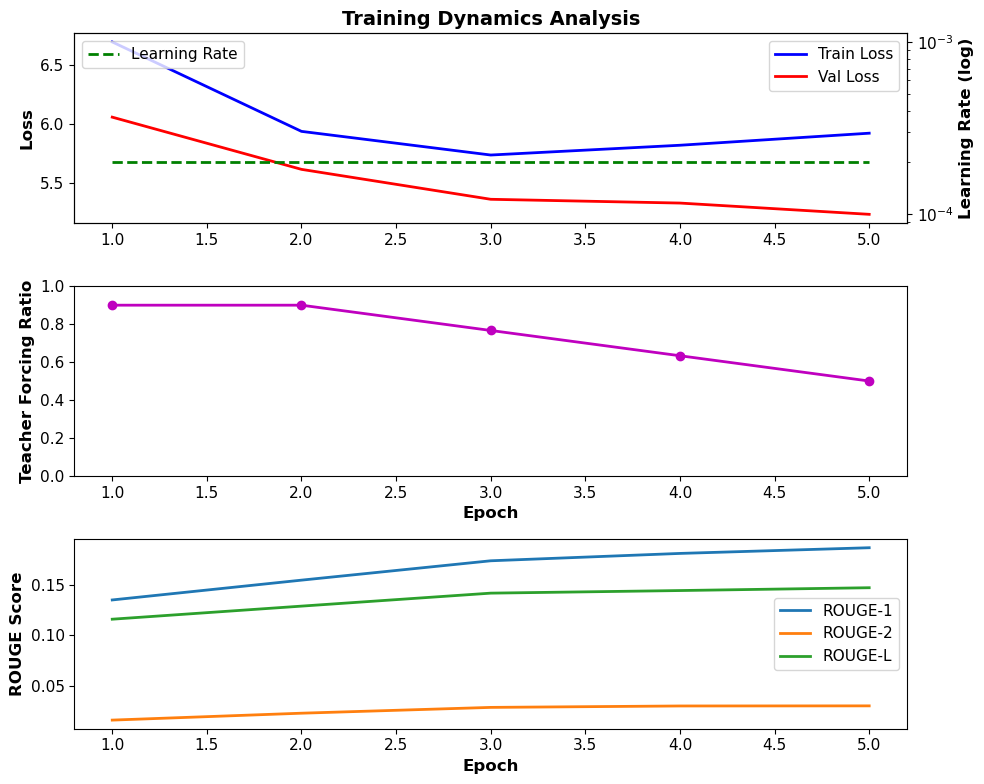

In [9]:
# load data
history = load_history("label_smoothing_history.json")
visualize_training_dynamics(history, save_path="label_smoothing_losses_wide.png")

### Inference Rouge Result

In [2]:
# libraries for inference
from pathlib import Path

def main():
    # 1. Configuration setup
    set_seed(42)
    config = {
        "vocab_size": 20000,
        "dropout": 0.1,
        "d_model": 512,
        "nhead": 8,
        "num_encoder_layers": 4,
        "num_decoder_layers": 4,
        "dim_feedforward": 2048
    }

    # 2. Initialize with automatic GPU selection
    tokenizer = Tokenizer.from_file("cnn_bpe_tokenizer_20k.json")
    device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")  # Auto-select GPU
    output_dir = Path("label_smooth_inf_results")
    output_dir.mkdir(exist_ok=True)

    # 3. Model setup with MAXIMUM optimization
    model = create_small_transformer(**config).to(device)
    model.load_state_dict(torch.load('label_smoothing_final_model.pt'))
    model.eval()
    
    # 4. ULTIMATE performance optimizations
    torch.backends.cuda.enable_flash_sdp(True)
    torch.backends.cuda.enable_mem_efficient_sdp(True)
    torch.set_float32_matmul_precision('high')
    torch.backends.cuda.enable_math_sdp(True)  # Fallback option
    
    # 5. Data loader with optimized settings
    test_loader = get_test_loader(
        tokenizer,
        batch_size=64,  # Adjusted for your GPU
        num_workers=2   # Increased from 2
        # pin_memory=True  # Faster data transfer
    )

    # 6. SUPERCHARGED inference pipeline
    generated_summaries = []
    reference_summaries = []
    demo_examples = []
    demo_count = 5
    
    with torch.no_grad(), torch.cuda.amp.autocast():
        for batch_idx, batch in enumerate(tqdm(test_loader, desc="Processing batches")):
            # Memory management
            if batch_idx % 10 == 0:
                torch.cuda.empty_cache()
                
            # Get batch data
            input_ids = batch['input_ids'].to(device, non_blocking=True)  # shape: [64, seq_len]
            labels = batch['labels'].to(device, non_blocking=True)
            
            # Process EACH sequence in the batch
            batch_summaries = []
            for seq_idx in range(input_ids.size(0)):  # Loop through batch dimension
                summary = generate_with_beam_search(
                    model=model,
                    input_ids=input_ids[seq_idx],  # Pass individual sequence
                    tokenizer=tokenizer,
                    device=device,
                    beam_width=3,
                    max_length=40
                )
                batch_summaries.append(summary)
            
            # Store results
            generated_summaries.extend(batch_summaries)
            batch_references = [tokenizer.decode(label.tolist(), skip_special_tokens=True) 
                            for label in labels]
            reference_summaries.extend(batch_references)
            
            # Save examples
            if len(demo_examples) < demo_count:
                for i in range(min(len(batch_summaries), demo_count - len(demo_examples))):
                    demo_examples.append({
                        "input": tokenizer.decode(input_ids[i].tolist(), skip_special_tokens=True)[:200] + "...",
                        "generated": batch_summaries[i],
                        "reference": batch_references[i]
                    })
                    
    # 7. Save outputs
    rouge_results = calculate_and_save_rouge(
        generated_summaries=generated_summaries,
        reference_summaries=reference_summaries,
        output_path=str(output_dir/"label_smooth_rouge_scores.json")
    )
    
    with open(output_dir/"label_smooth_demo_examples.json", 'w') as f:
        json.dump(demo_examples, f, indent=2)
    
    print("\nResults saved to:")
    print(f"- Full ROUGE scores: {output_dir/'label_smooth_rouge_scores.json'}")
    print(f"- Example summaries: {output_dir/'label_smooth_demo_examples.json'}")
    print(f"\nProcessed {len(generated_summaries)} samples (Batch size=64, Workers=2)")

if __name__ == "__main__":
    main()

Processing batches: 100%|██████████| 180/180 [40:47<00:00, 13.60s/it]



Results saved to:
- Full ROUGE scores: label_smooth_inf_results/label_smooth_rouge_scores.json
- Example summaries: label_smooth_inf_results/label_smooth_demo_examples.json

Processed 11490 samples (Batch size=64, Workers=2)
